# Taller Bases de datos y Pandas: El dúo dinámico, para el análisis eficiente
Recuerda la VPN está activada para conectarse a MySQL

Crear ambiente virtual
! conda create -n pyladiesmty python=3.9

Activar ambiente virtual
! conda activate pyladiesmty

In [1]:
! pip install pymysql cryptography pandas dotenv matplotlib seaborn openpyxl

In [2]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import dotenv_values

In [3]:
config = dotenv_values(".env")

DB_HOST = config["DB_HOST"]
DB_PORT = int(config["DB_PORT"])
DB_USER = config["DB_USER"]
DB_PASS = config["DB_PASS"]
DB_NAME = config["DB_NAME"]
DB_CHAR = config["DB_CHAR"]

In [4]:
year = "2024"

In [5]:
connection_str = f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(connection_str)
path = "data_airbnb_cdmx_2024"

## Retos

### 1. Identificar las colonias con propiedades más caras

In [6]:
query_expensive = """
SELECT neighbourhood, AVG(price) AS avg_price
FROM listings
GROUP BY neighbourhood
ORDER BY avg_price DESC;
"""

df_expensive = pd.read_sql_query(query_expensive, engine)
#df_expensive = df_expensive.sort_values('avg_price', ascending=False)
df_expensive.head()

,neighbourhood,avg_price
0,Cuauhtémoc,2311.346806
1,Miguel Hidalgo,2227.104273
2,Cuajimalpa de Morelos,2100.044248
3,Álvaro Obregón,1877.044653
4,Milpa Alta,1582.150000


/var/folders/3f/2vygd8615pz215mt4l1v091r0000gn/T/ipykernel_21183/522330361.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x='neighbourhood', y='avg_price', palette='viridis')


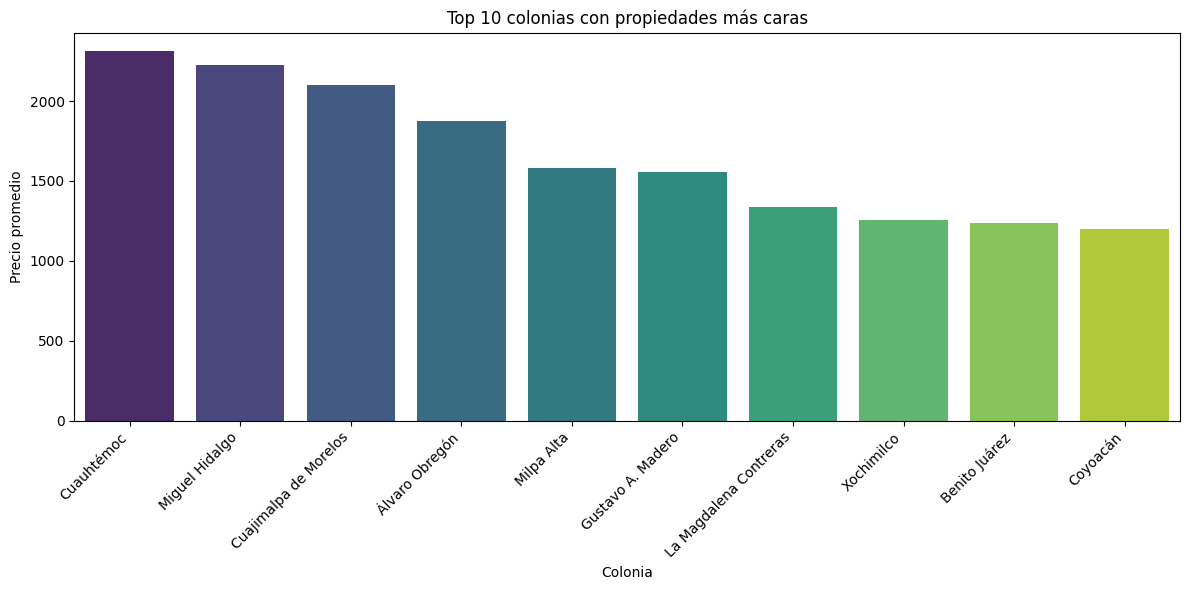

In [7]:
top10 = df_expensive.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top10, x='neighbourhood', y='avg_price', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Colonia")
plt.ylabel("Precio promedio")
plt.title("Top 10 colonias con propiedades más caras")
plt.tight_layout()
plt.show()

### 2. Contar el número de reseñas por propiedad

In [8]:
query_reviews = """
SELECT listing_id, COUNT(*) AS num_reviews
FROM reviews
GROUP BY listing_id;
"""

df_reviews = pd.read_sql_query(query_reviews, engine)
df_reviews.head()

,listing_id,num_reviews
0,44616,64
1,67703,50
2,70644,131
3,165772,367
4,796477,147


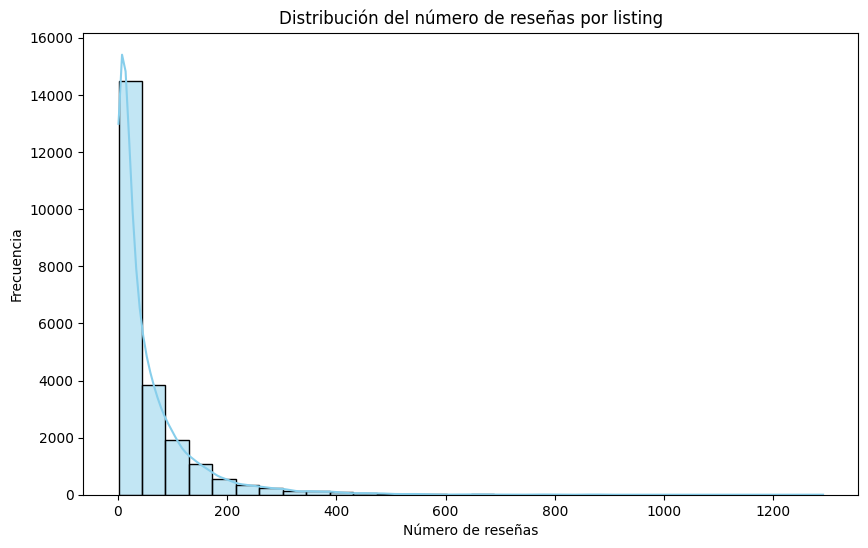

In [9]:
# Histograma con una curva de densidad (KDE) que muestra la distribución del número de reseñas por cada listing.
# - Frecuencia: Cuántos listings tienen un determinado número de reseñas.
# - Tendencia central: Es probable que la mayoría de los listings tenga pocas reseñas 
#             (por ejemplo, uno o dos), lo que se reflejará en una mayor altura de la barra en esos rangos.
# - Cola larga: Habrá algunos listings con un número muy alto de reseñas, pero son menos frecuentes, 
#             lo que se muestra con barras mucho más bajas a la derecha.
# - Forma general: La curva de densidad ayuda a visualizar la “suavidad” de la distribución, permitiendo 
#             identificar si la distribución es sesgada hacia la derecha (más listings con pocas reseñas y 
#             unos pocos con muchas).
# En resumen, la gráfica indica que la gran mayoría de los listings reciben pocas reseñas, 
# mientras que solo unos pocos acumulan un número significativamente mayor. Esto es típico en 
# plataformas donde la mayoría de los usuarios o propiedades son menos activos en cuanto a reseñas.

plt.figure(figsize=(10, 6))
sns.histplot(df_reviews['num_reviews'], bins=30, kde=True, color='skyblue')
plt.xlabel("Número de reseñas")
plt.ylabel("Frecuencia")
plt.title("Distribución del número de reseñas por listing")
plt.show()

/var/folders/3f/2vygd8615pz215mt4l1v091r0000gn/T/ipykernel_21183/324533150.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_reviews, x='listing_id', y='num_reviews', palette='viridis')


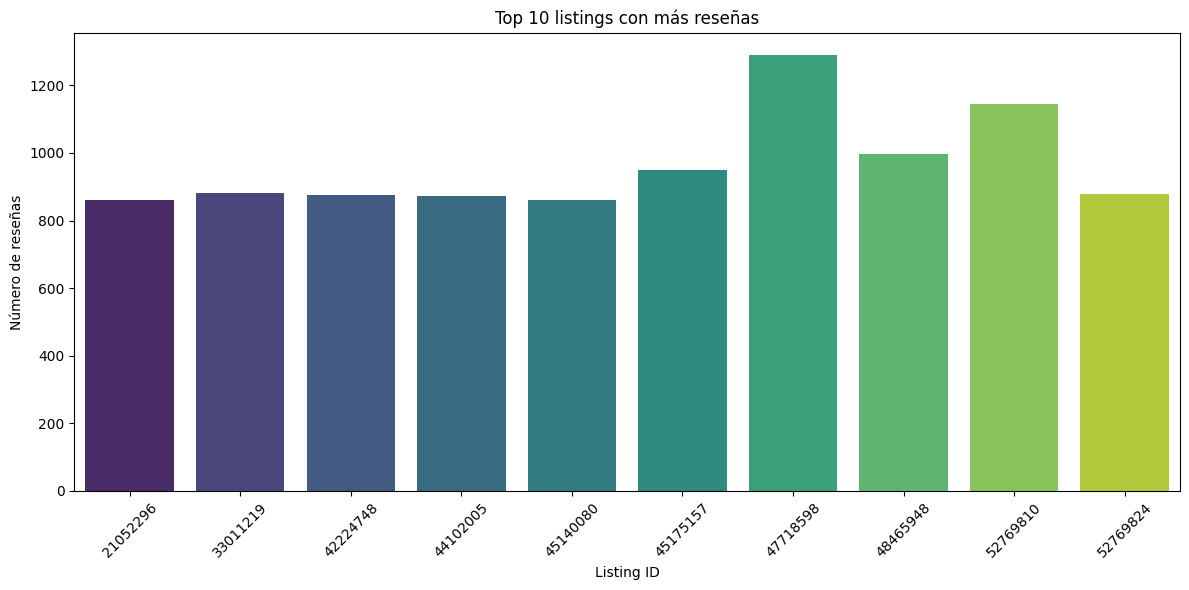

In [10]:
# Ordenar el DataFrame de mayor a menor número de reseñas y obtener los top 10
top10_reviews = df_reviews.sort_values(by='num_reviews', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top10_reviews, x='listing_id', y='num_reviews', palette='viridis')
plt.xlabel("Listing ID")
plt.ylabel("Número de reseñas")
plt.title("Top 10 listings con más reseñas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3. Calcular la disponibilidad promedio por tipo de habitación

In [11]:
query_availability = """
SELECT room_type, AVG(availability_365) AS avg_availability
FROM listings
GROUP BY room_type;
"""

df_avail = pd.read_sql_query(query_availability, engine)
df_avail.head()

,room_type,avg_availability
0,Entire home/apt,219.9210
1,Private room,224.9653
2,Hotel room,197.7209
3,Shared room,276.5965


/var/folders/3f/2vygd8615pz215mt4l1v091r0000gn/T/ipykernel_21183/1233018225.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='room_type', y='avg_availability', data=df_avail, palette='viridis')


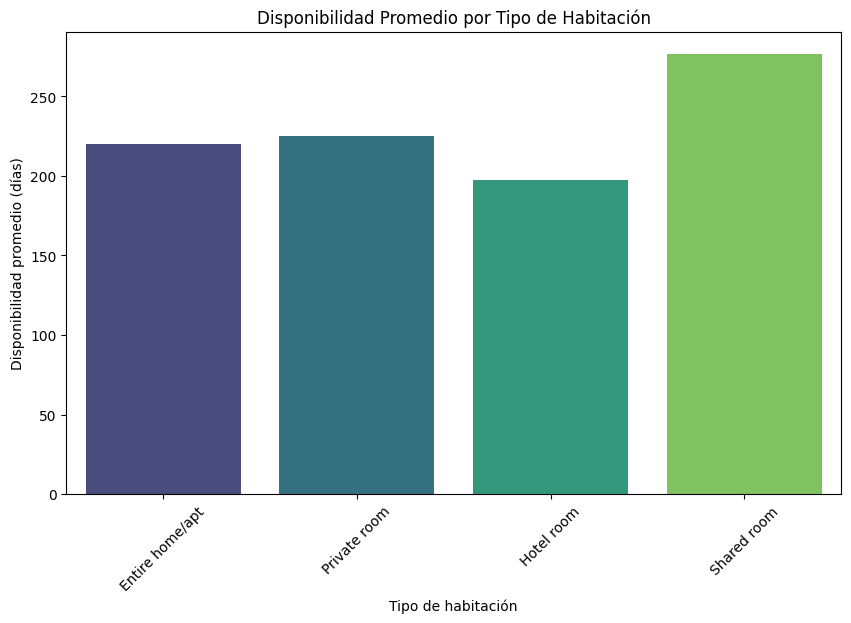

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(x='room_type', y='avg_availability', data=df_avail, palette='viridis')
plt.xlabel('Tipo de habitación')
plt.ylabel('Disponibilidad promedio (días)')
plt.title('Disponibilidad Promedio por Tipo de Habitación')
plt.xticks(rotation=45)
plt.show()

### 4. Ganancia promedio por tipo de habitación
Ingreso potencial = Precio * (365 - availability_365)

donde: 
availability_365 número de días en el año en que la propiedad está disponible (sin reservar)

In [13]:
# Consulta para calcular la ganancia promedio por tipo de habitación
query_revenue = """
SELECT room_type, AVG((365 - availability_365) * price) AS avg_revenue
FROM listings
GROUP BY room_type;
"""

df_revenue = pd.read_sql_query(query_revenue, engine)
df_revenue.head()

,room_type,avg_revenue
0,Entire home/apt,278651.824449
1,Private room,110017.773615
2,Hotel room,696034.027397
3,Shared room,40508.185841


/var/folders/3f/2vygd8615pz215mt4l1v091r0000gn/T/ipykernel_21183/3832016206.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='room_type', y='avg_revenue', data=df_revenue, palette='viridis')


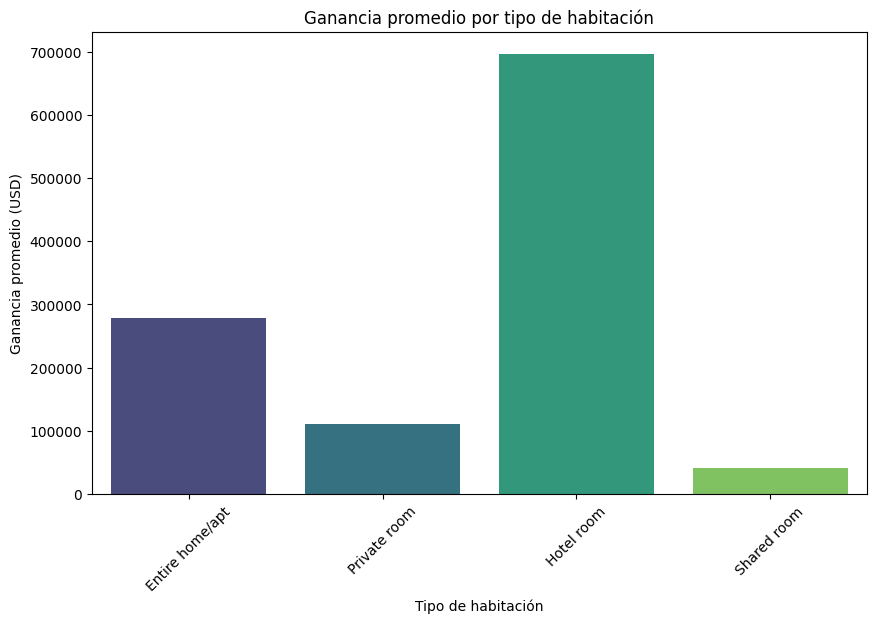

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x='room_type', y='avg_revenue', data=df_revenue, palette='viridis')
plt.xlabel("Tipo de habitación")
plt.ylabel("Ganancia promedio (USD)")
plt.title("Ganancia promedio por tipo de habitación")
plt.xticks(rotation=45)
plt.legend([], [], frameon=False)
plt.show()

In [15]:
df_revenue['avg_revenue_daily'] = df_revenue['avg_revenue'] / 365
df_revenue

,room_type,avg_revenue,avg_revenue_daily
0,Entire home/apt,278651.824449,763.429656
1,Private room,110017.773615,301.418558
2,Hotel room,696034.027397,1906.942541
3,Shared room,40508.185841,110.981331


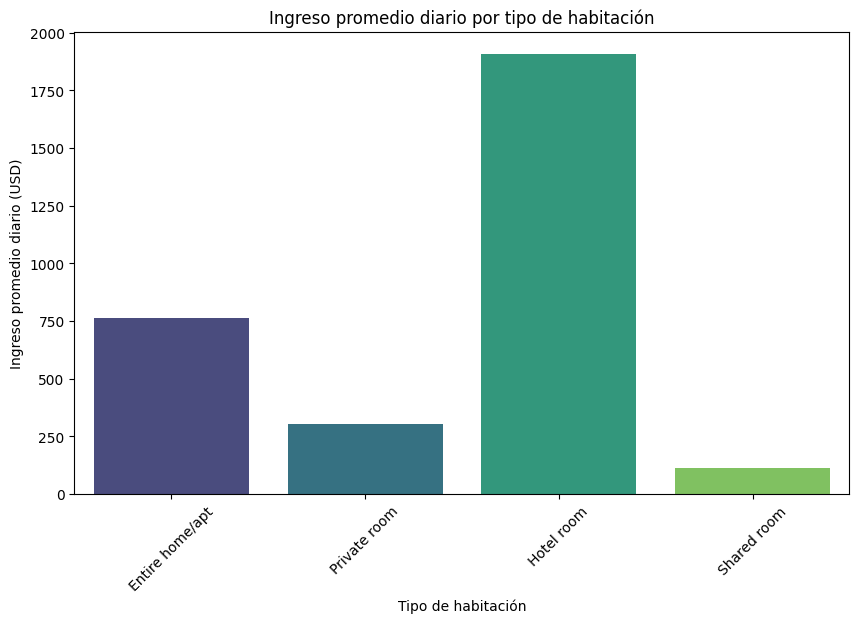

In [16]:
plt.figure(figsize=(10,6))
sns.barplot(data=df_revenue, x='room_type', y='avg_revenue_daily', hue='room_type', palette='viridis', dodge=False)
plt.xlabel("Tipo de habitación")
plt.ylabel("Ingreso promedio diario (USD)")
plt.title("Ingreso promedio diario por tipo de habitación")
plt.xticks(rotation=45)
plt.legend([], [], frameon=False)
plt.show()

### 5. Exportar a Excel

In [17]:
# Exportar a Excel
df_expensive.to_excel(f"{path}/analyzed/expensive_neighbourhoods.xlsx", index=False)
df_reviews.to_excel(f"{path}/analyzed/reviews_per_property.xlsx", index=False)
df_avail.to_excel(f"{path}/analyzed/availability_by_room_type.xlsx", index=False)

## Análisis de airbnb.reviews

In [18]:
query = """
    SELECT YEAR(review_date) AS year, COUNT(*) AS total_reviews
    FROM reviews
    GROUP BY YEAR(review_date)
"""
reviews_summary = pd.read_sql(query, engine)
reviews_summary

,year,total_reviews
0,2011,50
1,2012,264
2,2013,678
3,2014,1648
4,2015,4579
5,2016,13820
6,2017,31286
7,2018,61850
8,2019,100459
9,2020,63944


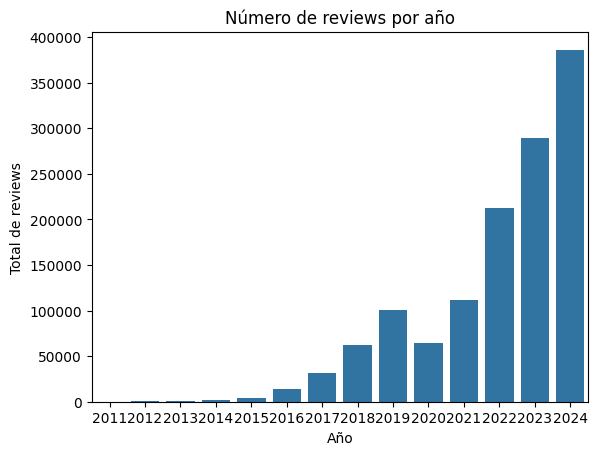

In [19]:
sns.barplot(data=reviews_summary, x='year', y='total_reviews')
plt.title("Número de reviews por año")
plt.xlabel("Año")
plt.ylabel("Total de reviews")
plt.show()

In [20]:
chunks = pd.read_sql_query(
    f"""SELECT id, listing_id, review_date
        FROM reviews 
        WHERE YEAR(review_date) = {year}""", engine, chunksize=100000)
reviews_2024 = pd.concat(chunks)
reviews_2024.head()

,id,listing_id,review_date
0,111,67703,2024-02-11
1,112,67703,2024-03-04
2,113,67703,2024-05-05
3,114,67703,2024-10-30
4,238,70644,2024-06-04


In [21]:
reviews_2024.count

<bound method DataFrame.count of             id           listing_id review_date
0          111                67703  2024-02-11
1          112                67703  2024-03-04
2          113                67703  2024-05-05
3          114                67703  2024-10-30
4          238                70644  2024-06-04
...        ...                  ...         ...
86081  1278544  1308251169465732784  2024-12-14
86082  1278545  1308251169465732784  2024-12-16
86083  1278546  1308251169465732784  2024-12-18
86084  1278547  1308251169465732784  2024-12-21
86085  1278548  1308251169465732784  2024-12-22

[386086 rows x 3 columns]>

In [22]:
# Convertir la columna review_date a datetime
reviews_2024['review_date'] = pd.to_datetime(reviews_2024['review_date'], errors='coerce')
# Crear columnas adicionales para analisis temporal
reviews_2024['month'] = reviews_2024['review_date'].dt.month
reviews_2024['week'] = reviews_2024['review_date'].dt.isocalendar().week
reviews_2024['day'] = reviews_2024['review_date'].dt.day
reviews_2024['weekday'] = reviews_2024['review_date'].dt.dayofweek
reviews_2024.head()

,id,listing_id,review_date,month,week,day,weekday
0,111,67703,2024-02-11,2,6,11,6
1,112,67703,2024-03-04,3,10,4,0
2,113,67703,2024-05-05,5,18,5,6
3,114,67703,2024-10-30,10,44,30,2
4,238,70644,2024-06-04,6,23,4,1


In [23]:
# Numero de reviews por mes
reviews_by_month = reviews_2024.groupby('month').size().reset_index(name='total_reviews')
reviews_by_month

,month,total_reviews
0,1,25083
1,2,30873
2,3,32522
3,4,29342
4,5,28442
5,6,28480
6,7,31197
7,8,34276
8,9,38053
9,10,38709


<Axes: title={'center': 'Reviews mensuales en 2024'}, xlabel='month'>

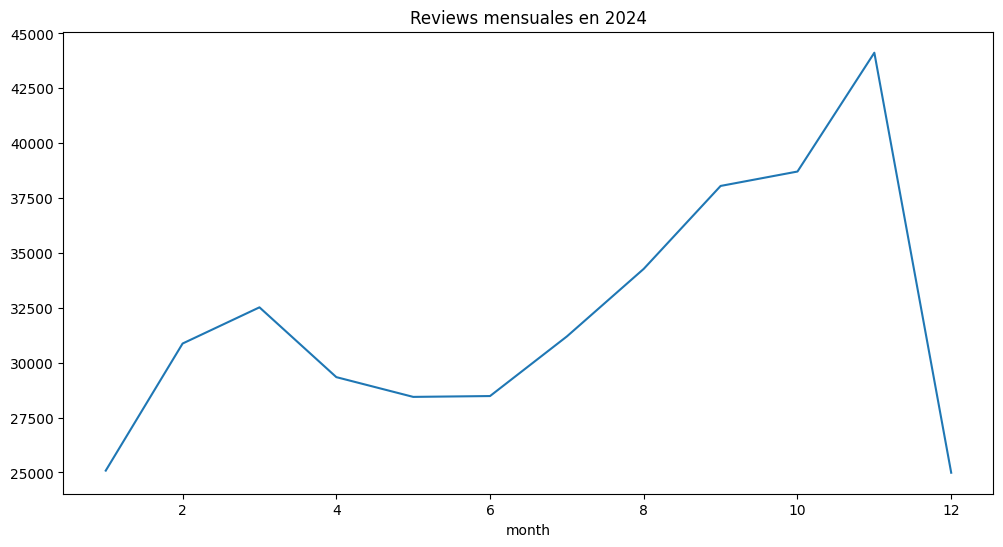

In [24]:
reviews_by_month.set_index('month')['total_reviews'].plot(figsize=(12, 6), title=f"Reviews mensuales en {year}")

<Axes: title={'center': 'Reviews semanales en 2024'}, xlabel='week'>

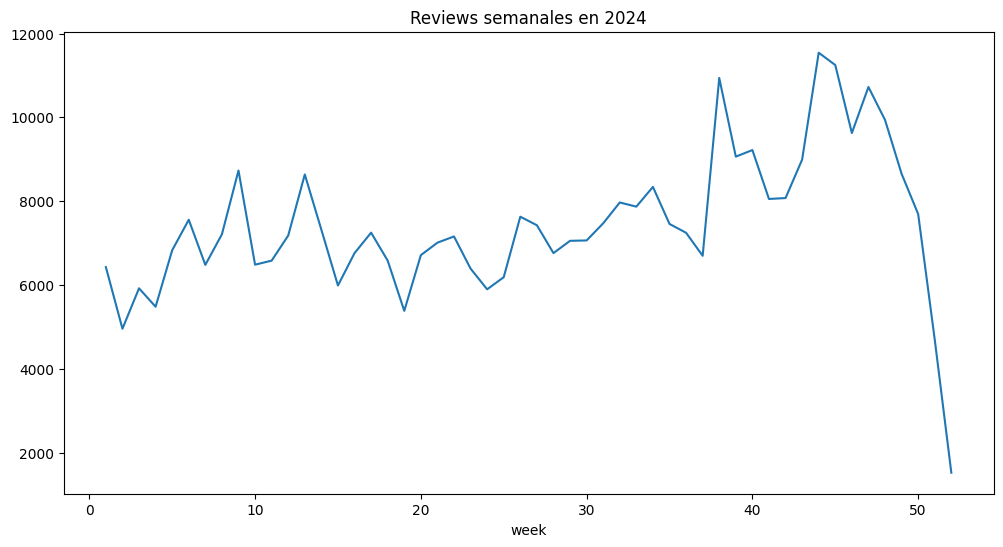

In [25]:
# Reviews semanales
reviews_weekly = reviews_2024.groupby('week').size().reset_index(name='total_reviews')
reviews_weekly.set_index('week')['total_reviews'].plot(figsize=(12, 6), title=f"Reviews semanales en {year}")

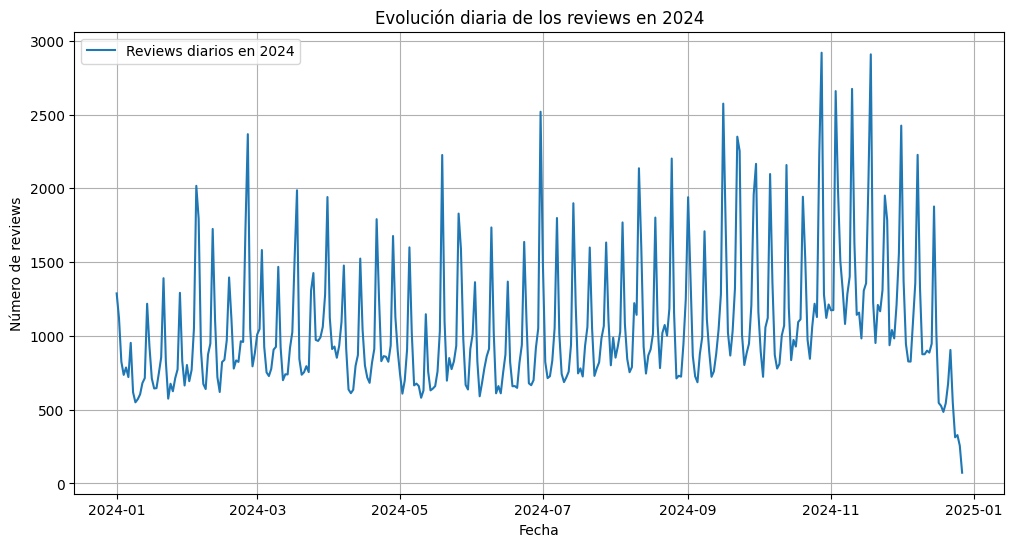

In [26]:
# Reviews diarios
reviews_daily = reviews_2024.groupby('review_date').size().reset_index(name='total_reviews')
reviews_daily.set_index('review_date', inplace=True)

plt.figure(figsize=(12,6))
plt.plot(reviews_daily.index, reviews_daily['total_reviews'], label=f'Reviews diarios en {year}')
plt.title("Evolución diaria de los reviews en 2024")
plt.xlabel("Fecha")
plt.ylabel("Número de reviews")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Cálculo del promedio diario
total_reviews_2024 = len(reviews_2024)
promedio_diario = total_reviews_2024 / 366
print(f"Promedio diario de reviews: {promedio_diario:.0f}")

Promedio diario de reviews: 1055


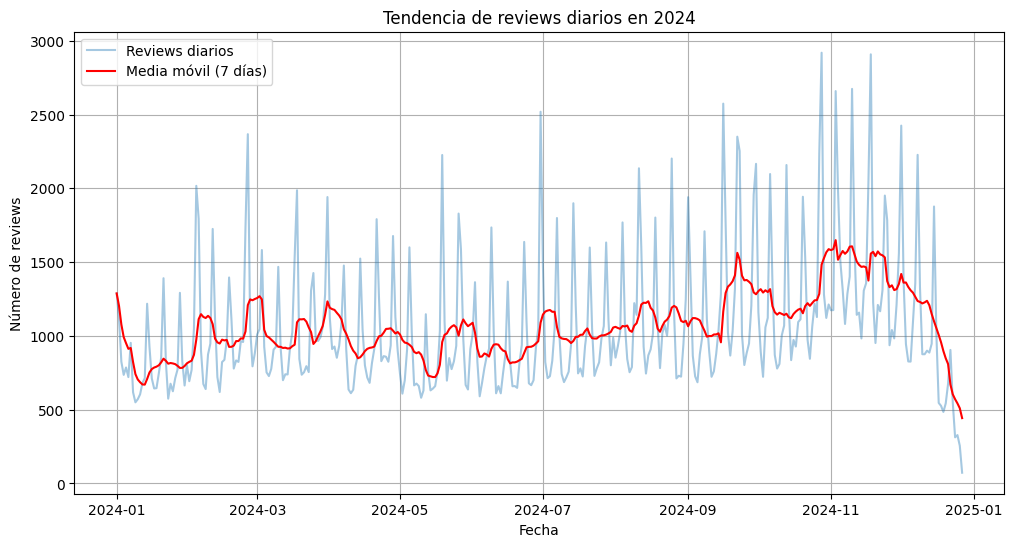

In [28]:
# 4. Análisis de tendencias y días atípicos
# a) Suavizado de la serie temporal
# Puedes aplicar una media móvil para suavizar la serie y visualizar la tendencia:
# La media móvil ayuda a eliminar la volatilidad diaria y resalta la tendencia general, facilitando la detección de patrones estacionales o cambios repentinos.
reviews_daily['rolling_mean'] = reviews_daily['total_reviews'].rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(12,6))
plt.plot(reviews_daily.index, reviews_daily['total_reviews'], alpha=0.4, label='Reviews diarios')
plt.plot(reviews_daily.index, reviews_daily['rolling_mean'], color='red', label='Media móvil (7 días)')
plt.title("Tendencia de reviews diarios en 2024")
plt.xlabel("Fecha")
plt.ylabel("Número de reviews")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Identificar de días atípicos:
# Los días con diferencias muy altas (positivas o negativas) pueden señalar eventos específicos o anomalías en el sistema.
reviews_daily['diff'] = reviews_daily['total_reviews'] - reviews_daily['rolling_mean']
atipicos = reviews_daily[reviews_daily['diff'].abs() > reviews_daily['diff'].std() * 2]
print("Días atípicos:")
print(atipicos[['total_reviews', 'rolling_mean', 'diff']])

Días atípicos:
             total_reviews  rolling_mean         diff
review_date                                          
2024-02-04            2017    975.571429  1041.428571
2024-02-26            2367   1208.857143  1158.142857
2024-03-18            1987   1092.142857   894.857143
2024-04-21            1791    965.857143   825.142857
2024-05-19            2226    958.857143  1267.142857
2024-05-26            1829   1001.428571   827.571429
2024-06-09            1735    913.000000   822.000000
2024-06-30            2519   1090.000000  1429.000000
2024-07-14            1899    965.857143   933.142857
2024-08-11            2136   1138.428571   997.571429
2024-08-25            2202   1191.571429  1010.428571
2024-09-01            1940   1065.285714   874.714286
2024-09-16            2574   1165.285714  1408.714286
2024-09-30            2166   1282.285714   883.714286
2024-10-13            2158   1150.428571  1007.571429
2024-10-27            2234   1284.571429   949.428571
2024-10-28   

In [30]:
# Comparar con años anteriores
# Si tienes los totales anuales de otros años, por ejemplo, 2023 con 289,602 reviews, puedes calcular el crecimiento:
reviews_2023 = 289602
crecimiento = (total_reviews_2024 - reviews_2023) / reviews_2023 * 100
print(f"Crecimiento interanual de 2023 a 2024: {crecimiento:.2f}%")

Crecimiento interanual de 2023 a 2024: 33.32%


In [31]:
# --- Análisis de tendencias temporales (ejemplo para 2024 en reviews) ---
# Número de reviews por mes
reviews_2024['month'] = reviews_2024['review_date'].dt.month
reviews_by_month = reviews_2024.groupby('month').size().reset_index(name='total_reviews')
print("Reviews por mes en 2024:")
print(reviews_by_month)

Reviews por mes en 2024:
    month  total_reviews
0       1          25083
1       2          30873
2       3          32522
3       4          29342
4       5          28442
5       6          28480
6       7          31197
7       8          34276
8       9          38053
9      10          38709
10     11          44122
11     12          24987


/var/folders/3f/2vygd8615pz215mt4l1v091r0000gn/T/ipykernel_21183/3686409509.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='total_reviews', data=reviews_by_month, palette="viridis")


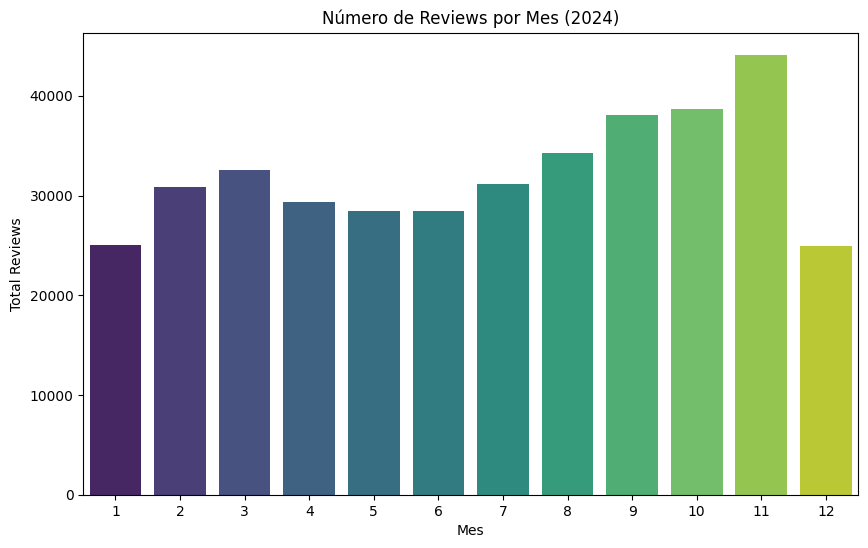

In [32]:
plt.figure(figsize=(10,6))
sns.barplot(x='month', y='total_reviews', data=reviews_by_month, palette="viridis")
plt.title("Número de Reviews por Mes (2024)")
plt.xlabel("Mes")
plt.ylabel("Total Reviews")
plt.show()

## Análisis de airbnb.listings

In [33]:
listings = pd.read_sql("SELECT * FROM listings", engine)
listings.count()

id                                26281
name                              26281
host_id                           26281
host_name                         26278
neighbourhood_group                   0
neighbourhood                     26281
latitude                          26281
longitude                         26281
room_type                         26281
price                             22466
minimum_nights                    26281
number_of_reviews                 26281
last_review                       22985
reviews_per_month                 22985
calculated_host_listings_count    26281
availability_365                  26281
number_of_reviews_ltm             26281
license                               0
dtype: int64

In [34]:
# Resumen estadístico de las columnas numéricas
listings.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,2.628100e+04,2.628100e+04,26281.000000,26281.000000,22466.000000,26281.000000,26281.000000,22985.000000,26281.000000,26281.000000,26281.000000
mean,5.685595e+17,2.221993e+08,19.404972,-99.166480,1932.216015,4.594878,48.649138,1.803403,16.573000,221.710057,14.813630
std,5.084605e+17,1.901217e+08,0.042641,0.033149,8173.797083,23.678089,78.329465,2.037176,39.985179,131.460012,21.297668
min,3.579700e+04,7.365000e+03,19.177848,-99.339630,116.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,4.062158e+07,5.145291e+07,19.391180,-99.178980,669.000000,1.000000,3.000000,0.460000,1.000000,89.000000,0.000000
50%,7.042914e+17,1.609579e+08,19.414950,-99.167606,1114.000000,2.000000,19.000000,1.230000,3.000000,264.000000,7.000000
75%,1.040058e+18,3.852822e+08,19.431900,-99.154710,1900.000000,2.000000,61.000000,2.550000,11.000000,349.000000,22.000000
max,1.319510e+18,6.685337e+08,19.561010,-98.963360,868511.000000,1125.000000,1291.000000,63.930000,238.000000,365.000000,547.000000


In [35]:
# Ver cuál es el tipo de alojamiento más común en la plataforma.
room_counts = listings['room_type'].value_counts().reset_index()
room_counts.columns = ['room_type', 'count']
room_counts

,room_type,count
0,Entire home/apt,17430
1,Private room,8608
2,Hotel room,129
3,Shared room,114


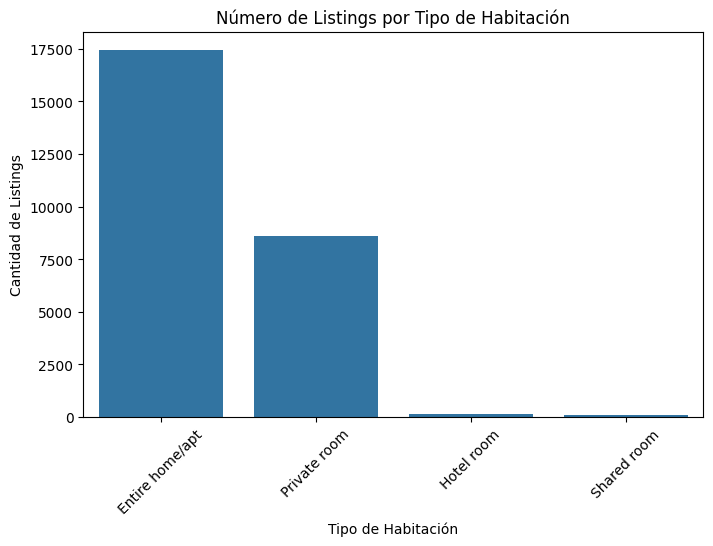

In [36]:

plt.figure(figsize=(8, 5))
sns.barplot(x='room_type', y='count', data=room_counts)
plt.title("Número de Listings por Tipo de Habitación")
plt.xlabel("Tipo de Habitación")
plt.ylabel("Cantidad de Listings")
plt.xticks(rotation=45)
plt.show()

In [37]:
# Identificar en qué zonas se concentra la oferta de alojamientos.
neighbourhood_counts = listings['neighbourhood'].value_counts().reset_index()
neighbourhood_counts.columns = ['neighbourhood', 'count']
neighbourhood_counts.head(10)  # Mostrar las 10 principales zonas

,neighbourhood,count
0,Cuauhtémoc,12133
1,Miguel Hidalgo,4496
2,Benito Juárez,3045
3,Coyoacán,1725
4,Álvaro Obregón,1032
5,Tlalpan,810
6,Venustiano Carranza,754
7,Gustavo A. Madero,484
8,Cuajimalpa de Morelos,421
9,Iztacalco,406


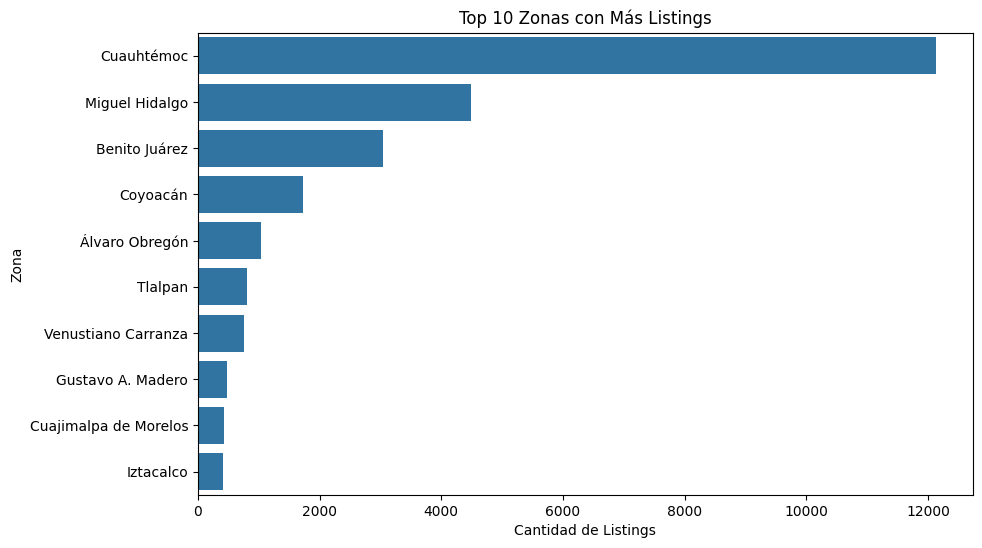

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='neighbourhood', data=neighbourhood_counts.head(10))
plt.title("Top 10 Zonas con Más Listings")
plt.xlabel("Cantidad de Listings")
plt.ylabel("Zona")
plt.show()

In [39]:
# Convertir review_date a datetime sin infer_datetime_format
if 'review_date' in reviews_2024.columns:
    reviews_2024['review_date'] = pd.to_datetime(reviews_2024['review_date'], errors='coerce')
reviews_2024.head()

,id,listing_id,review_date,month,week,day,weekday
0,111,67703,2024-02-11,2,6,11,6
1,112,67703,2024-03-04,3,10,4,0
2,113,67703,2024-05-05,5,18,5,6
3,114,67703,2024-10-30,10,44,30,2
4,238,70644,2024-06-04,6,23,4,1


In [40]:
# Ejemplo: Conteo de reviews por listing
reviews_count = reviews_2024.groupby('listing_id').size().reset_index(name='num_reviews')
print("Número de reviews por listing (ejemplo):")
reviews_2024.head(10)

Número de reviews por listing (ejemplo):


,id,listing_id,review_date,month,week,day,weekday
0,111,67703,2024-02-11,2,6,11,6
1,112,67703,2024-03-04,3,10,4,0
2,113,67703,2024-05-05,5,18,5,6
3,114,67703,2024-10-30,10,44,30,2
4,238,70644,2024-06-04,6,23,4,1
5,239,70644,2024-08-17,8,33,17,5
6,240,70644,2024-08-31,8,35,31,5
7,241,70644,2024-09-22,9,38,22,6
8,242,70644,2024-10-05,10,40,5,5
9,243,70644,2024-11-06,11,45,6,2


In [41]:
# Unir reviews con listings para analizar la relación precio vs reviews
if 'id' in listings.columns:
    listings_reviews = pd.merge(listings, reviews_count, left_on='id', right_on='listing_id', how='left')
    listings_reviews['num_reviews'] = listings_reviews['num_reviews'].fillna(0)
listings_reviews[['id', 'price', 'num_reviews']].sort_values(by="num_reviews")

,id,price,num_reviews
0,35797,4044.0,0.0
10388,53182129,650.0,0.0
10389,53182916,1116.0,0.0
10392,53188085,1100.0,0.0
10394,53188737,614.0,0.0
...,...,...,...
20672,1089826814804817475,4574.0,381.0
15776,851378885484711252,1363.0,400.0
20675,1089827300651785197,2848.0,439.0
16113,867327163490316624,1054.0,450.0


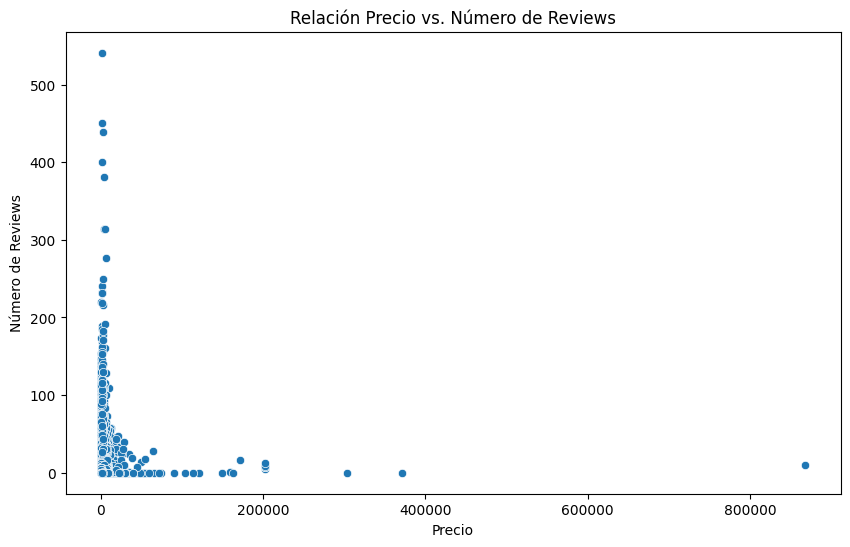

In [42]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='price', y='num_reviews', data=listings_reviews)
plt.title("Relación Precio vs. Número de Reviews")
plt.xlabel("Precio")
plt.ylabel("Número de Reviews")
plt.show()

## Análisis de airbnb.calendars

In [43]:
# Calcular la tasa de ocupación global por mes (para 2025, por ejemplo)

chunksize = 500000  # Ajusta según la memoria disponible
chunk_list = []  # Para acumular resultados parciales
year = "2025"
query = f"""SELECT calendar_date, available 
FROM calendars 
WHERE YEAR(calendar_date)={year}"""

for chunk in pd.read_sql_query(query, engine, chunksize=chunksize):
    chunk['calendar_date'] = pd.to_datetime(chunk['calendar_date'], errors='coerce')
    chunk['month'] = chunk['calendar_date'].dt.month
    chunk['available_num'] = chunk['available'].map({'t': 1, 'f': 0, True: 1, False: 0})
    # Agrupar por mes y contar el total de días y los disponibles
    agg = chunk.groupby('month').agg(total_days=('available_num', 'count'),
                                     available_days=('available_num', 'sum'))
    # Calculamos la tasa de ocupación (1 - disponibilidad)
    agg['occupancy_rate'] = 1 - (agg['available_days'] / agg['total_days'])
    chunk_list.append(agg)

In [44]:
# Concatenamos los resultados parciales y promediamos 
occupancy_by_month = pd.concat(chunk_list).groupby(level=0).sum()
occupancy_by_month['occupancy_rate'] = 1 - (occupancy_by_month['available_days'] / occupancy_by_month['total_days'])

print(f"Tasa de ocupación global por mes en {year}:")
print(occupancy_by_month)

Tasa de ocupación global por mes en 2025:
       total_days  available_days  occupancy_rate
month                                            
1          814711          462095        0.432811
2          735868          486946        0.338270
3          814711          597301        0.266855
4          788430          537836        0.317839
5          814711          576970        0.291810
6          788430          548914        0.303789
7          814711          501194        0.384820
8          814711          500834        0.385262
9          788430          464425        0.410950
10         814711          413600        0.492335
11         788430          401906        0.490245
12         698102          354564        0.492103


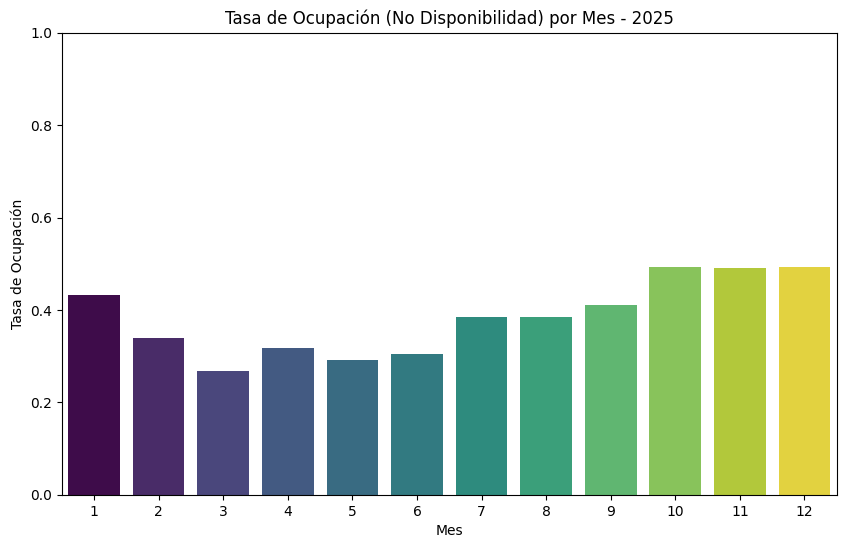

In [45]:
# Posible explicacion de datos de 2025
# 1. Reservas anticipadas
# 2. Datos simulados o proyecciones
plt.figure(figsize=(10,6))
sns.barplot(x=occupancy_by_month.index, 
            y=occupancy_by_month['occupancy_rate'], 
            hue=occupancy_by_month.index, 
            palette="viridis", 
            legend=False)
plt.title(f"Tasa de Ocupación (No Disponibilidad) por Mes - {year}")
plt.xlabel("Mes")
plt.ylabel("Tasa de Ocupación")
plt.ylim(0, 1)
plt.show()